In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

In [3]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 29 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [4]:
data_bz = data["b2dz5"]  
data_bx = data["b2dx5"]  
data_by = data["b2dy5"]  

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 40.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 40.0 * 10**-3
pixelsize_y_Mm = 40.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 2000.0 * 10**-3

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 3.2 3.2 2.0
nresol_x, nresol_y, nresol_z 80 80 50
pixelsize_x 0.04
pixelsize_y 0.04
pixelsize_z 0.04


In [5]:
print(z0)

2.0


In [6]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [7]:
data2d = Field2dData(nresol_x, nresol_y, nresol_z, nf_max, pixelsize_x_Mm, pixelsize_y_Mm, pixelsize_z_Mm, x_arr, y_arr, z_arr, data_bz)

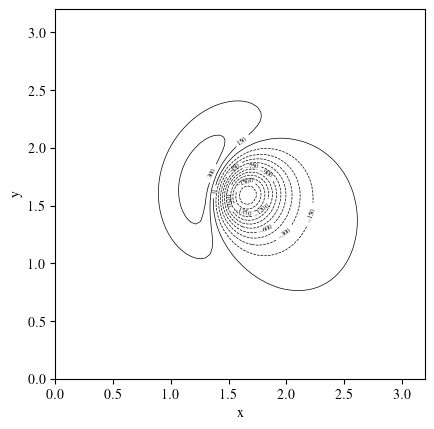

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    18,
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(1)
plt.show()

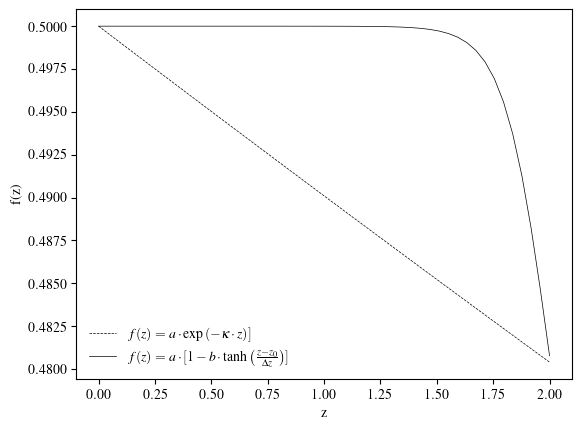

In [9]:
from mhsflex.switch import f, f_low

deltaz = z0 * 0.1

f_exp = np.zeros(nresol_z)
f_tanh = np.zeros(nresol_z)
b = 0.04
a = 0.5 / (1 + b)
alpha = -0.3

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f_exp[iz] = f_low(z, 0.5, 0.02)
    f_tanh[iz] = f(z, z0, deltaz, a, b)

plt.plot(
    z_arr,
    f_exp,
    label=r"$f(z) = a \cdot \exp\left(- \kappa \cdot z \right)]$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f_tanh,
    label=r"$f(z) = a \cdot [1 - b \cdot \tanh\left(\frac{z - z_0}{\Delta z}\right)]$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.show()

In [10]:
data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)

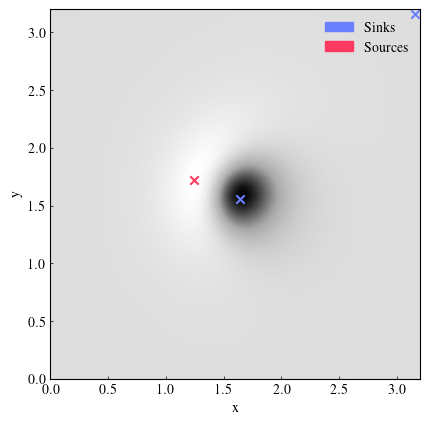

In [43]:
show_poles(data3d)

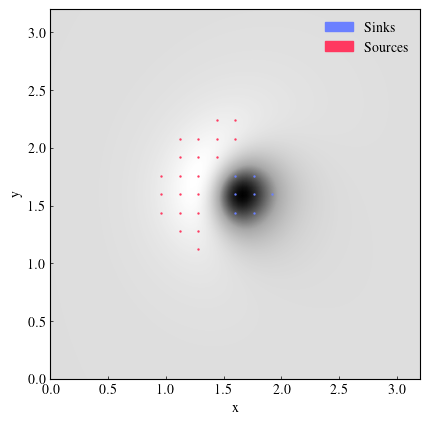

In [42]:
show_footpoints(data3d)

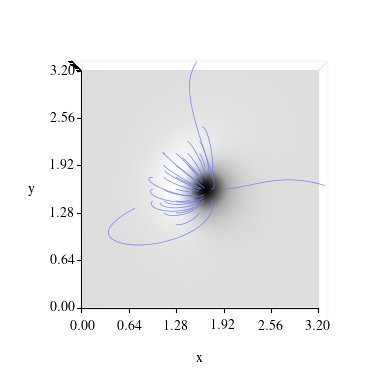

In [36]:
plot(data3d, 'los')

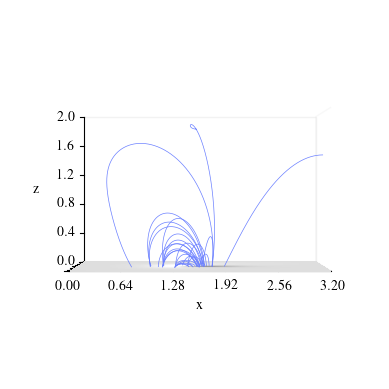

In [37]:
plot(data3d, 'side')

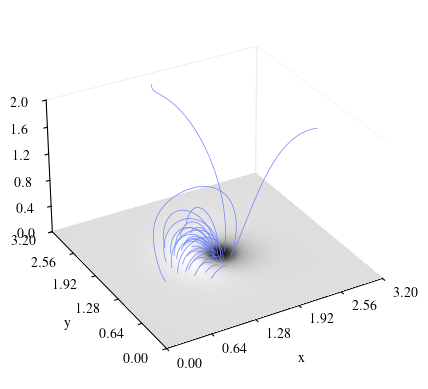

In [38]:
plot(data3d, 'angular')

In [16]:
pathref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
dataref = readsav(pathref, python_dict=True, verbose=True)

data_bx_ref = dataref["b3dx"]
data_by_ref = dataref["b3dy"]
data_bz_ref = dataref["b3dz"]

presref = dataref["p3d"] * 10**-1
denref = dataref["d3d"] * 10**3

reffield = np.zeros_like((data3d.field))

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, int(nresol_z/2)):
            reffield[i, j, k, 1] = data_bx_ref[k, i, j]
            reffield[i, j, k, 0] = data_by_ref[k, i, j]
            reffield[i, j, k, 2] = data_bz_ref[k, i, j]

refdata3d = Field3dData(nresol_x, nresol_y, nresol_z, nf_max, x_arr, y_arr, z_arr, data3d.bz, reffield, reffield, a, b, alpha, z0, deltaz)

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 8 are of type VARIABLE
 - 1 are of type NOTICE
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


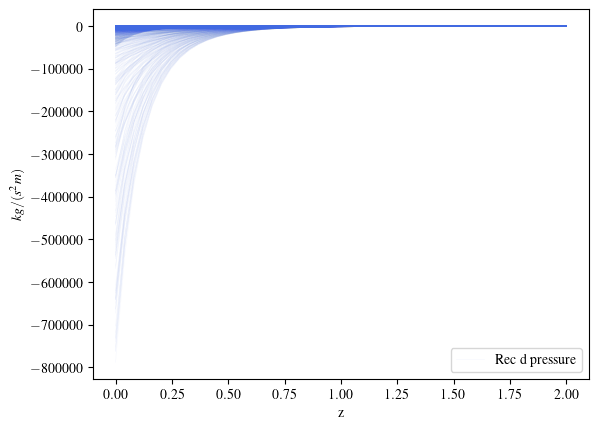

In [17]:
plt.plot(
    z_arr,
    data3d.dpressure[0, 0, :],
    linewidth=0.5,
    color="royalblue",
    alpha=0.04,
    label="Rec d pressure",
)
for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, data3d.dpressure[iy, ix, :], linewidth=0.5, color="royalblue", alpha=0.04
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend()
plt.show()

In [18]:
temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

from mhsflex.field3d import bpressure_linear, bdensity_linear, btemp_linear, fpressure_linear, fdensity_linear

backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

In [19]:
maxcoord = np.unravel_index(
    np.argmax(data3d.bz, axis=None),
    data3d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

In [20]:
fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

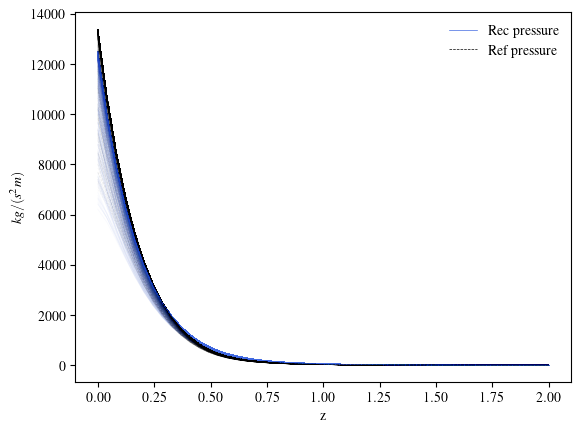

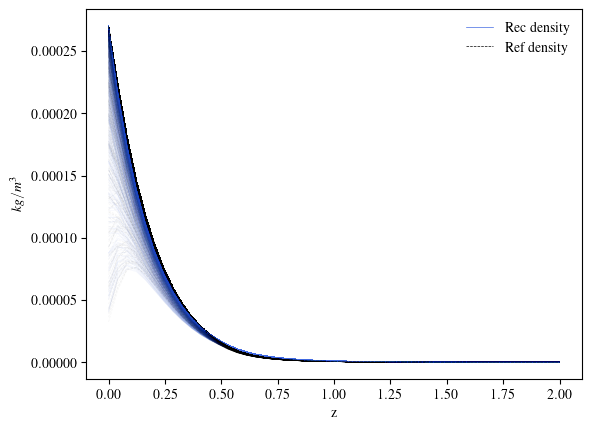

In [21]:
plt.plot(
    z_arr,
    fpres[0, 0, :],
    linewidth=0.5,
    color="royalblue",
    label="Rec pressure",
)
plt.plot(
    z_arr,
    presref[:, 0, 0],
    linewidth=0.5,
    color="black",
    linestyle="dashed",
    label="Ref pressure",
)
for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, fpres[iy, ix, :], linewidth=0.5, color="royalblue", alpha=0.04
        )
        plt.plot(
            z_arr,
            presref[:, iy, ix],
            linewidth=0.5,
            color="black",
            linestyle="dashed",
            alpha=0.04,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.show()

plt.plot(
    z_arr,
    fden[0, 0, :],
    linewidth=0.5,
    color="royalblue",
    label="Rec density",
)
plt.plot(
    z_arr,
    denref[:, 0, 0],
    linewidth=0.5,
    color="black",
    linestyle="dashed",
    label="Ref density",
)
for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, fden[iy, ix, :], linewidth=0.5, color="royalblue", alpha=0.04
        )
        plt.plot(
            z_arr,
            denref[:, iy, ix],
            linewidth=0.5,
            color="black",
            linestyle="dashed",
            alpha=0.04,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.show()

In [ ]:
# Comparing using metrics needs to be adjusted